In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
import math

import plotly.express as px
import sqlite3

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score as shs

# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
# Suskirstykite eismo įvykius į klasterius (2022 metų) (pagal koordinantes, atskirai kiekvienai eismo įvykio rūšiai, su 
# DBSCAN bei KMeans). Darydami KMeans klasterizaciją, pasinaudokite elbow grafiku optimaliam klasterių skaičiaus nustatymu
# (Jei pavyksta)
# Patekite vizualizacijas klasterių išsidėstymo su mapbox()
# Pasirinkite vieną eismo įvykių rūšį, ir su GridsearchCV, GridSearch klase suraskite optimalų klasterių kiekį
# Tada taip pat pateikite klasterių vizualizacijas.

In [2]:
df = pd.read_json(path_or_buf='https://data.gov.lt/media/filer_public/5e/b8/5eb89d55-f57a-48ec-b1a2-063692c1b6a7/ei_2022_12_31.json', convert_dates=['dataLaikas'])
df = df[['dataLaikas', 'iskaitinis','dalyviuSkaicius','rusis', 'ilguma','platuma']].dropna(subset=['ilguma','platuma'])

In [3]:
from LKS94WGS84 import *
LAT, LON = [],[]

for ilguma, platuma in zip(df['ilguma'],df['platuma']):
    lat, lon = grid2geo(platuma, ilguma)
    LAT.append(lat)
    LON.append(lon)

df['long'] = LON
df['lat'] = LAT

In [4]:
df.head()

dataLaikas  iskaitinis  dalyviuSkaicius                      rusis  \
0 2021-12-31 22:00:00           0              1.0         Kiti eismo įvykiai   
1 2022-01-01 00:40:00           0              2.0                Susidūrimas   
2 2022-01-01 02:02:00           0              1.0    Užvažiavimas ant gyvūno   
3 2022-01-01 01:53:00           0              1.0                 Apvirtimas   
4 2021-12-31 12:35:00           0              1.0  Užvažiavimas ant kliūties   

      ilguma   platuma       long        lat  
0  6083759.0  491606.0  23.869164  54.889850  
1  6181902.0  317439.0  21.092653  55.737249  
2  6161589.0  333263.0  21.356655  55.560661  
3  6104844.0  630436.0  26.041968  55.062240  
4  6102529.0  495530.0  23.930034  55.058543

In [8]:
eismo_ivykiai = df['rusis'].unique()

In [14]:
len(eismo_ivykiai)

11

In [13]:
fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="long",
    zoom=6, 
    title="Visi eismo įvykiai",
    color="rusis"
)

fig.update_layout(
    mapbox_style="open-street-map",  
    height=600
)

fig.show()

In [20]:
ivykiu_skaicius=df['rusis'].value_counts()
top_4_ivykiai = ivykiu_skaicius.head(4).index

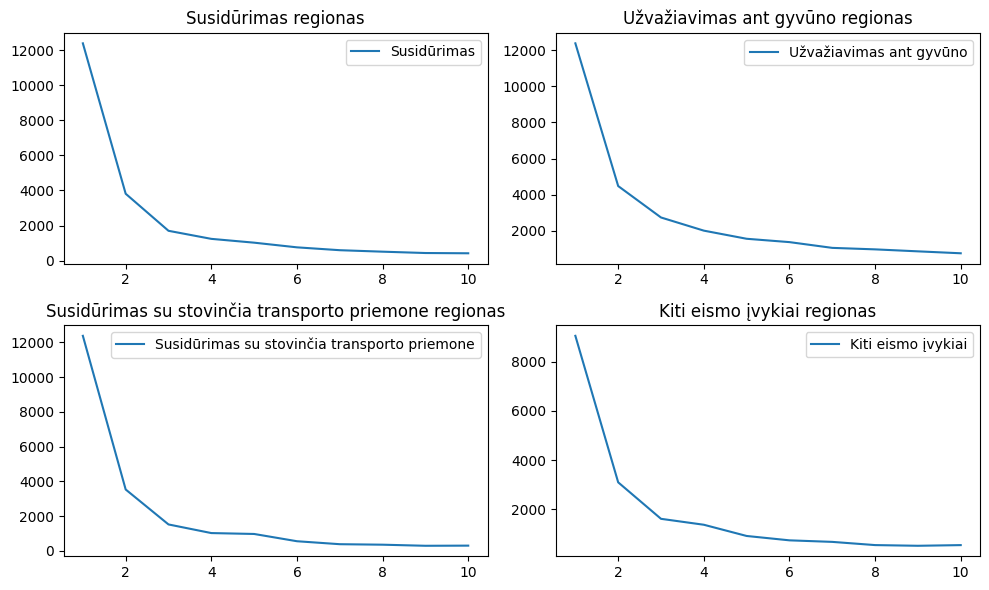

In [32]:

rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

axes = axes.flatten()

for idx, i in enumerate(top_4_ivykiai):

    df_test=df[df['rusis']==i]
    
    sse = []
    for k in range(1,11):
        km = KMeans(n_clusters=k)
        km.fit(df_test[['long', 'lat']])
        sse.append(km.inertia_)

    ax = sns.lineplot(x=[*range(1,11)], y=sse, label=i,  ax=axes[idx])
    
    axes[idx].set_title(f'{i} regionas')
    
    if idx >= rows * cols - 1:
        break

plt.tight_layout()
plt.show()


In [79]:
def zemelapis(df, ivykis, n_clusters=3):

    kmeans = KMeans(n_clusters=n_clusters)

    df_test=df[df['rusis']==ivykis].copy()
    predicted_labels = kmeans.fit_predict(df_test[['long', 'lat']])
    df_test['cluster'] = predicted_labels

    fig = px.scatter_mapbox(
        df_test,
        lat="lat",
        lon="long", 
        color='cluster',
        zoom=6,
        size_max=50, 
        title=(f"{ivykis} KMeans"),
    )

    fig.update_layout(
        mapbox_style="open-street-map",  
        height=600
    )

    fig.show()

In [80]:
for i in top_4_ivykiai:
    zemelapis(df, i, 4)

In [81]:
def zemelapisDBSCAN(df, ivykis):
    
    df_test=df[df['rusis']==ivykis].copy()

    df_test['dbscan'] = DBSCAN(eps=0.15, min_samples=50).fit_predict(df_test[['lat', 'long']])

    fig = px.scatter_mapbox(
        df_test,
        lat="lat",
        lon="long", 
        color='dbscan',
        zoom=6,
        size_max=50, 
        title=(f"{ivykis} DBSCAN"),
    )

    fig.update_layout(
        mapbox_style="open-street-map",  
        height=600
    )

    fig.show()

In [82]:
for i in top_4_ivykiai:
    zemelapisDBSCAN(df, i)